In this capter, we will cover the following recipes:
- Creating the dataset.
- Defining the model.
- Training the model.
- Deploying the video classification model.

## Splitting the data

Here we will split the dataset into training and test sets.

### 1. Let's define the data path and import myutils:

In [1]:
import os
import myutils

In [2]:
path_to_data = "../data"
sub_folder_jpg = "hmdb51_jpg"
path_to_jpgs = os.path.join(path_to_data, sub_folder_jpg)

### 2. The frames of each video were stored in a folder with the same name as the video. Call the get_vids helper function from myutils to get a list of video filenames and labels:

In [3]:
all_vids, all_labels, categories = myutils.get_vids(path_to_jpgs)

In [4]:
len(all_vids), len(all_labels), len(categories)

(6766, 6766, 51)

In [5]:
all_vids[:3], all_labels[:3], categories[:5]

(['../data/hmdb51_jpg/ride_horse/Alifestyle_ride_horse_f_cm_np1_le_med_7',
  '../data/hmdb51_jpg/ride_horse/Return_of_the_King_1_ride_horse_f_cm_np2_fr_med_2',
  '../data/hmdb51_jpg/ride_horse/Glory_ride_horse_f_nm_np1_fr_med_14'],
 ['ride_horse', 'ride_horse', 'ride_horse'],
 ['ride_horse', 'pushup', 'eat', 'laugh', 'situp'])

### 3. Define a Python dictionary to hold the numerical values of the labels:

In [6]:
labels_dict = {}
index = 0
for uc in categories:
    labels_dict[uc] = index
    index = index + 1
labels_dict

{'ride_horse': 0,
 'pushup': 1,
 'eat': 2,
 'laugh': 3,
 'situp': 4,
 'stand': 5,
 'cartwheel': 6,
 'shoot_bow': 7,
 'shake_hands': 8,
 'turn': 9,
 'shoot_gun': 10,
 'smoke': 11,
 'pick': 12,
 'smile': 13,
 'catch': 14,
 'push': 15,
 'talk': 16,
 'kiss': 17,
 'golf': 18,
 'kick': 19,
 'punch': 20,
 'ride_bike': 21,
 'hit': 22,
 'pour': 23,
 'flic_flac': 24,
 'drink': 25,
 'wave': 26,
 'draw_sword': 27,
 'brush_hair': 28,
 'jump': 29,
 'run': 30,
 'walk': 31,
 'pullup': 32,
 'shoot_ball': 33,
 'climb': 34,
 'swing_baseball': 35,
 'chew': 36,
 'sword_exercise': 37,
 'throw': 38,
 'climb_stairs': 39,
 'clap': 40,
 'fencing': 41,
 'sword': 42,
 'sit': 43,
 'fall_floor': 44,
 'dribble': 45,
 'kick_ball': 46,
 'dive': 47,
 'hug': 48,
 'handstand': 49,
 'somersault': 50}

### 4. As we can see, there is a total of 51 categories. To simplify this problem, we will select five action classes and filter out videos:

In [7]:
num_classes = 5
unique_ids = [id_ for id_, label in zip(all_vids, all_labels)
             if labels_dict[label] < num_classes]
unique_labels = [label for id_, label in zip(all_vids, all_labels)
                if labels_dict[label] < num_classes]
len(unique_ids), len(unique_labels)

(560, 560)

### 5. Split the videos into two groups:

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

In [9]:
strat_shuffle_split = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_index, test_index = next(strat_shuffle_split.split(unique_ids, unique_labels))
train_ids = [unique_ids[ind] for ind in train_index]
train_labels = [unique_labels[ind] for ind in train_index]
print(len(train_ids), len(train_labels))

test_ids = [unique_ids[ind] for ind in test_index]
test_labels = [unique_labels[ind] for ind in test_index]
print(len(test_ids), len(test_labels))

504 504
56 56


## Defininig the PyTorch datasets

### 1. Import the essential packages:

In [10]:
from torch.utils.data import Dataset, DataLoader, Subset
import glob
from PIL import Image
import torch
import numpy as np
import random
np.random.seed(2020)
random.seed(2020)
torch.manual_seed(2020)

### 2. Define the dataset class:

In [11]:
class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.transform = transform
        self.ids = ids
        self.labels = labels
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        path_to_images = glob.glob(self.ids[idx] + "/*.jpg")
        path_to_images = path_to_images[:timesteps]
        label = labels_dict[self.labels[idx]]
        frames = []
        for path_to_img in path_to_images:
            frame = Image.open(path_to_img)
            frames.append(frame)
            
        seed = np.random.randint(1e9)
        frames_transformed = []
        for frame in frames:
            random.seed(seed)
            np.random.seed(seed)
            frame = self.transform(frame)
            frames_transformed.append(frame)
        if len(frames_transformed) > 0:
            frames_transformed = torch.stack(frames_transformed)
        return frames_transformed, label

### 3. Define the transformation parameters:

In [12]:
# choose one
model_type = "3dcnn"
model_type = "rnn"

timesteps = 16

if model_type == "rnn":
    height, width = 224, 224
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
else:
    height, width = 112, 112
    mean = [0.43216, 0.394666, 0.37645]
    std = [0.22803, 0.22145, 0.216989]

### 4. Define the image transformations for training:

In [13]:
import torchvision.transforms as transforms

train_transformer = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0,
                           translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

### 5. Instantiate an object of the dataset class:

In [14]:
train_dataset = VideoDataset(ids=train_ids, labels=train_labels, transform=train_transformer)
print(len(train_dataset))

504


### 6. Get a sample from train_ds:

In [15]:
image, label = train_dataset[1]
if len(image) > 0:
    print(image.shape, label, torch.min(image), torch.max(image))

torch.Size([16, 3, 224, 224]) 4 tensor(-2.1179) tensor(2.6400)


### 7. Let's display a few sample frames:

In [16]:
import matplotlib.pylab as plt
%matplotlib inline

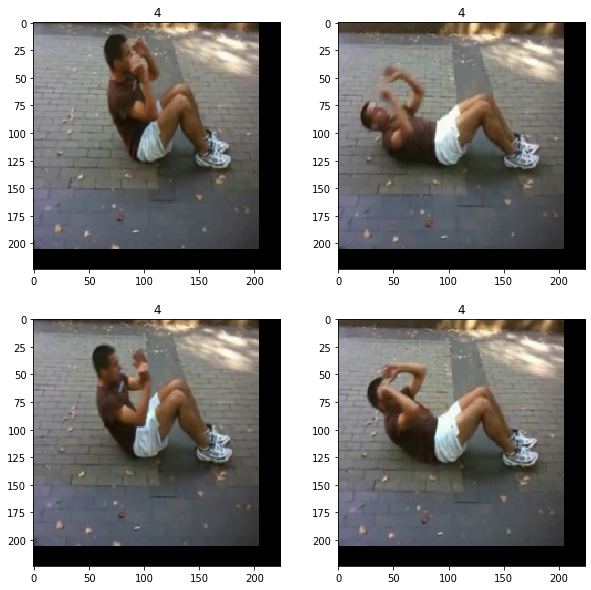

In [17]:
plt.figure(figsize=(10, 10))

for ii, img in enumerate(image[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(myutils.denormalize(img, mean, std))
    plt.title(label)

### 8. Define the transformations for the test dataset:

In [18]:
test_transformer = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

### 9. Instantiate an object of the VideoDataset class as test_dataset:

In [19]:
test_dataset = VideoDataset(ids=test_ids, labels=test_labels, transform=test_transformer)
print(len(test_dataset))

56


### 10. Get a sample item from test_ds:

In [20]:
images, label = test_dataset[1]
images.shape, label, torch.min(images), torch.max(images)

(torch.Size([16, 3, 224, 224]), 1, tensor(-2.1179), tensor(2.6400))

### 11. Let's display the sample item from test_dataset:

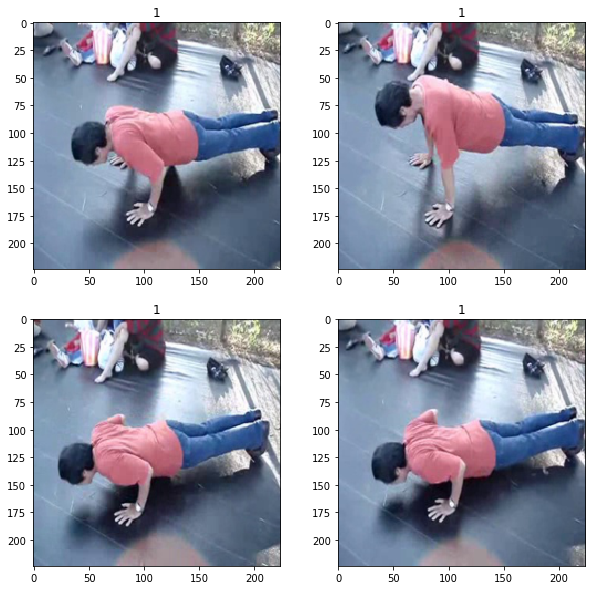

In [21]:
plt.figure(figsize=(10, 10))

for ii, image in enumerate(images[::4]):
    plt.subplot(2, 2, ii+1)
    plt.imshow(myutils.denormalize(image, mean, std))
    plt.title(label)

## Defining the data loaders

### 1. Define the data loaders:

In [22]:
# collate functions
def collate_fn_3dcnn(batch):
    images_batch, label_batch = list(zip(*batch))
    images_batch = [images for images in images_batch 
                    if len(images) > 0]
    label_batch = [torch.tensor(l) for l, images in zip(label_batch,
                                                       images_batch)
                  if len(images) > 0]
    images_tensor = torch.stack(images_batch)
    images_tensor = torch.transpose(images_tensor, 2, 1)
    labels_tensor = torch.stack(label_batch)
    return images_tensor, labels_tensor

def collate_fn_rnn(batch):
    images_batch, label_batch = list(zip(*batch))
    images_batch = [images for images in images_batch
                   if len(images) > 0]
    label_batch = [torch.tensor(l) for l, images in zip(label_batch,
                                                        images_batch)
                  if len(images) > 0]
    images_tensor = torch.stack(images_batch)
    labels_tensor = torch.stack(label_batch)
    return images_tensor, labels_tensor

In [23]:
batch_size = 16
if model_type == "rnn":
    train_dl = DataLoader(train_dataset,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   collate_fn=collate_fn_rnn)
    test_data_loader = DataLoader(test_dataset,
                                  batch_size=2*batch_size,
                                  shuffle=False,
                                  collate_fn=collate_fn_rnn)
else:
    train_dl = DataLoader(train_dataset,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   collate_fn=collate_fn_3dcnn)
    test_data_loader = DataLoader(test_dataset,
                                  batch_size=2*batch_size,
                                  shuffle=False,
                                  collate_fn=collate_fn_3dcnn)

### 2. Now, set the model type to "3dcnn" and get a mini-batch from train_dl:

In [24]:
for x_batch, y_batch in train_dl:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 16, 3, 224, 224]) torch.Size([16])


## Defining the model

### 1. Define the Resnet18Rnn:

In [25]:
from torch import nn

class Resnet18Rnn(nn.Module):
    def __init__(self, params_model):
        super(Resnet18Rnn, self).__init__()
        num_classes = params_model["num_classes"]
        dropout_rate = params_model["dropout_rate"]
        pretrained = params_model["pretrained"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        
        base_model = models.resnet18(pretrained=pretrained)
        num_features = base_model.fc.in_features
        base_model.fc = Identity()
        self.base_model= base_model
        self.dropout = nn.Dropout(dropout_rate)
        self.rnn = nn.LSTM(num_features, rnn_hidden_size,
                           rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        
    def forward(self, x):
        b_z, ts, c, height, width = x.shape
        ii = 0
        y = self.base_model((x[:, ii]))
        
        output, (hn, cn) = self.rnn(y.unsqueeze(1))
        
        for ii in range(1, ts):
            y = self.base_model((x[:, ii]))
            out, (hn, cn) = self.rnn(y.unsqueeze(1),
                                     (hn, cn))
        out = self.dropout(out[:, -1])
        out = self.fc1(out)
        return out
    
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x

### 2. Use a conditional statement to define either of the models:

In [26]:
from torchvision import models
from torch import nn

if model_type == "rnn":
    params_model = {
        "num_classes": num_classes,
        "dropout_rate": 0.1,
        "pretrained": True,
        "rnn_num_layers": 1,
        "rnn_hidden_size": 100,
    }
    
    model = Resnet18Rnn(params_model)
else:
    model = models.video.r3d_18(pretrained=True, progress=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

### 3. Let's test the model using some dummy input:

In [27]:
with torch.no_grad():
    if model_type == "rnn":
        x = torch.zeros(1, 16, 3, height, width)
    else:
        x = torch.zeros(1, 3, 16, height, width)
    y = model(x)
    print(y.shape)

torch.Size([1, 5])


### 4. Move the model to a CUDA device:

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### 5. Now, let's print the model:

In [29]:
print(model)

Resnet18Rnn(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

## Training the model

### 1. Define the loss function, optimizer, and learning rate schedule:

In [30]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau

loss_func = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=3e-5)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                            factor=0.5, patience=5,
                                            verbose=1)
os.makedirs("./models", exist_ok=True)

### 2. Call the train_val helper function from myutils to train the model:

In [31]:
params_train = {
    "num_epochs": 20,
    "optimizer": optimizer,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": test_data_loader,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path_to_weights": "./models/weights_" + model_type + ".pt",
    
}

model, loss_history, metric_history = myutils.train_val(model,
                                                        params_train)

Epoch 0/19, current lr = 3e-05


ValueError: too many values to unpack (expected 2)